In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all" # all last_expr

# Libraries and Parameters

In [2]:
import os
import math
import matplotlib.pyplot as plt

from itertools import chain
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

import torch
import torch.nn.functional as F
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader

In [3]:
NUM_CLASSES = 5

MINI_BS = 1
BS = 128
assert BS%MINI_BS==0
LR = 1e-3
N_SUBSET = -BS*20 #10000
EPOCHS = 200

N_EVAL = BS*20
MAX_TOKENS = 384
OVERLAP_TOKENS = 64

DEVICE = "cuda:1"

SAVE_PATH = "Checkpoint/Siemens_allFeat_epoch_{}_batch_{}.pth"


# NLP Model

In [4]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=NUM_CLASSES)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Dataset

In [90]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, nlp_model, datadir):
        self.df = df
        self.tokenizer = tokenizer
        self.nlp_model = nlp_model
        self.datadir = datadir
        self.device = nlp_model.device

        if not os.path.exists(self.datadir):
            os.makedirs(self.datadir, exist_ok=True)
            self.nlp_model.eval()
            with torch.no_grad():
                for idx in tqdm(range(0,df.shape[0],MINI_BS)):
                    id = self.df["ID"].iloc[idx:idx+MINI_BS].astype(int).to_list()
                    id = torch.tensor(id).to(self.device)
                    
                    summary = self.df["summary"].iloc[idx:idx+MINI_BS].to_list()
                    positives = self.df["positives"].iloc[idx:idx+MINI_BS].to_list()
                    negatives = self.df["negatives"].iloc[idx:idx+MINI_BS].to_list()
                    advice_to_mgmt = self.df["advice_to_mgmt"].iloc[idx:idx+MINI_BS].to_list()                    
                    
                    inp_summary = self.tokenizer(summary,
                                   truncation = True,
                                   padding = True,
                                   max_length=MAX_TOKENS,
                                   # stride=OVERLAP_TOKENS,
                                   return_tensors="pt").to(self.device)
                    inp_pos = self.tokenizer(positives,
                               truncation = True,
                               padding = True,
                               max_length=MAX_TOKENS,
                               # stride=OVERLAP_TOKENS,
                               return_tensors="pt").to(self.device)
                    inp_neg = self.tokenizer(negatives,
                               truncation = True,
                               padding = True,
                               max_length=MAX_TOKENS,
                               # stride=OVERLAP_TOKENS,
                               return_tensors="pt").to(self.device)
                    inp_advice = self.tokenizer(advice_to_mgmt,
                               truncation = True,
                               padding = True,
                               max_length=MAX_TOKENS,
                               # stride=OVERLAP_TOKENS,
                               return_tensors="pt").to(self.device)
                    out_summary = self.nlp_model(**inp_summary).pooler_output
                    out_pos = self.nlp_model(**inp_pos).pooler_output
                    out_neg = self.nlp_model(**inp_neg).pooler_output
                    out_advice = self.nlp_model(**inp_advice).pooler_output

                    scores1_5 = self.df[['score_1', 'score_2', 'score_3' , 'score_4', 'score_5']].iloc[idx:idx+MINI_BS].astype(int)
                    scores1_5 = torch.from_numpy(scores1_5.to_numpy()-1)
                    scores1_5 = F.one_hot(scores1_5, num_classes=NUM_CLASSES)
                    scores1_5 = scores1_5.view(scores1_5.shape[0],-1).to(self.device)
                                        
                    score6 = self.df['score_6'].iloc[idx:idx+MINI_BS].astype(int)
                    score6 = np.log(1+score6.to_numpy())
                    score6 = torch.from_numpy(score6).to(self.device)

                    target = self.df["overall"].astype(int).iloc[idx:idx+MINI_BS]
                    target = torch.from_numpy(target.to_numpy()-1).to(self.device)
                    
                    torch.save({"ID": id,
                                "summary": out_summary, 
                                "pos":out_pos, 
                                "neg":out_neg, 
                                "advice":out_advice, 
                                "scores1_5":scores1_5,
                                "score6":score6,
                                "target":target}, f'{self.datadir}/tensor_{idx}.t')
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data_idx = torch.load(f"{self.datadir}/tensor_{idx}.t", map_location=self.device) 
        
        return data_idx

In [75]:
def preprocess_df(df):
    df['summary'] = df['summary'].fillna('')
    df['positives'] = df['positives'].fillna('')
    df['negatives'] = df['negatives'].fillna('')
    df['advice_to_mgmt'] = df['advice_to_mgmt'].fillna('')
    df = df.dropna(subset=['score_1', 'score_2', 'score_3' , 'score_4', 'score_5', 'score_6']).reset_index(drop=True)
    return df[['ID','summary', 'positives', 'negatives', 'advice_to_mgmt', 'score_1', 'score_2', 'score_3' , 'score_4', 'score_5', 'score_6', 'overall']]


In [7]:
def collate_dict(batch):
    out_batch = {}
    for k in batch[0].keys():
        out_batch[k] = torch.cat([b[k] for b in batch],dim=0)
    return out_batch
    

In [8]:
df = pd.read_csv("NLP_Data/train.csv")#[['summary','positives','negatives','overall']]
df

,ID,Place,location,date,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall
0,1,startup_1,NaN,"Dec 11, 2018",Current Employee,Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,NaN,4.0,5.0,5.0,4.0,5.0,0,5.0
1,2,startup_1,"Mountain View, CA","Jun 21, 2013",Former Employee,Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,2.0,3.0,3.0,5.0,3.0,2094,5.0
2,3,startup_1,"New York, NY","May 10, 2014",Current Employee,Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,4.0,5.0,5.0,4.0,949,5.0
3,4,startup_1,"Mountain View, CA","Feb 8, 2015",Current Employee,Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,2.0,5.0,5.0,4.0,5.0,498,4.0
4,10,startup_1,NaN,"Dec 9, 2018",Current Employee,Anonymous Employee,Execellent for engineers,Impact driven. Best tech in the world.,Size matters. Engineers are a bit disconnected...,NaN,5.0,5.0,5.0,5.0,5.0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30331,67522,startup_6,NaN,"Dec 22, 2010",Former Employee,Senior Project Managet,Microsoft Services is bad.,MS is a good company but hire wrong people. Wo...,Senior management has no leadership and very o...,Major management revamp esp in APAC. It's not ...,3.0,NaN,1.5,2.0,1.0,0,2.0
30332,67524,startup_6,NaN,"Dec 17, 2010",Former Employee,Senior Program Manager,Good company.,"Good benefits package, huge customer base.","Politics, very slow, lots of dead wood.",Move on.,3.5,NaN,3.5,4.0,4.0,0,4.0
30333,67525,startup_6,NaN,"Dec 16, 2010",Former Employee,Anonymous Employee,Enriching experience for a beginner but bad fo...,"-Access to a wide range of technologies, compl...",-Testers(SDET's ) do not get as many opportuni...,Make the company leaner and Meaner. (which wou...,3.0,NaN,4.0,4.0,2.0,0,3.0
30334,67527,startup_6,NaN,"Dec 15, 2010",Current Employee,Account Manager,Good Place to Work,Nice place to work. Good atmosphere with advan...,Management confusion at times with vision for ...,NaN,3.0,NaN,4.0,4.5,3.5,0,4.0


## Train Dataset

In [9]:
df_train = preprocess_df(df)
df_train.isnull().sum()
df_train = df_train.iloc[:N_SUBSET]

summary           0
positives         0
negatives         0
advice_to_mgmt    0
score_1           0
score_2           0
score_3           0
score_4           0
score_5           0
score_6           0
overall           0
dtype: int64

In [10]:
loss_weights = torch.from_numpy(1./df_train.overall.value_counts().sort_index().to_numpy().astype(np.float64)).to(device)

loss_weights

tensor([0.0034, 0.0004, 0.0001, 0.0001, 0.0003], device='cuda:1',
       dtype=torch.float64)

In [11]:
train_dataset = TextDataset(df_train, tokenizer, model.bert, 'data_train')
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BS, 
                                           shuffle=True,
                                           collate_fn=collate_dict)

## Test Dataset

In [12]:
df_test = pd.read_csv("NLP_Data/train.csv")
df_test = preprocess_df(df_test)

In [13]:
df_test.isna().sum()
df_test = df_test.iloc[-N_EVAL:]

summary           0
positives         0
negatives         0
advice_to_mgmt    0
score_1           0
score_2           0
score_3           0
score_4           0
score_5           0
score_6           0
overall           0
dtype: int64

In [14]:
test_dataset = TextDataset(df_test, tokenizer, model.bert, 'data_train')
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=BS, 
                                           shuffle=True,
                                           collate_fn=collate_dict)

# Model

In [15]:
class NLPClassifier(nn.Module):
    def __init__(self, hidden_dim, out_classes, nlp_dropout=0.1):
        super(NLPClassifier,self).__init__()
        
        intermediate_dim = 128

        self.dropout1 = nn.Dropout(nlp_dropout)

        self.bn1 = nn.BatchNorm1d(intermediate_dim)
    
        self.ln1 = nn.Linear(4*hidden_dim, intermediate_dim)
        self.ln2 = nn.Linear(intermediate_dim, out_classes)

        self.relu = nn.ReLU()    

        
    def forward(self,summary, pos, neg, advice, scores1_5, score6):
        nlp_out = torch.cat([summary, pos, neg, advice], dim=-1)
        nlp_out = self.dropout1(nlp_out)
        nlp_out = self.relu(self.ln1(nlp_out))
        nlp_out =  self.bn1(nlp_out)

        nlp_out = self.ln2(nlp_out)

        return nlp_out

In [16]:
class TabClassifier(nn.Module):
    def __init__(self, hidden_dim, out_classes, tab_dropout=0.05):
        super(TabClassifier,self).__init__()

        # self.dropout = nn.Dropout(tab_dropout)
        
        self.bn1 = nn.BatchNorm1d(31)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.ln1 = nn.Linear(25,64)
        self.ln2 = nn.Linear(64,31)
        self.ln3 = nn.Linear(32, 128) 
        self.ln4 = nn.Linear(128, 64) 

        self.ln5 = nn.Linear(64, out_classes)
        
        self.relu = nn.ReLU()    

        
    def forward(self,summary, pos, neg, advice, scores1_5, score6):
        tab_out =  self.relu(self.ln1(scores1_5))
        tab_out =  self.relu(self.ln2(tab_out))
        tab_out =  self.bn1(tab_out)
        
        tab_out = torch.cat([tab_out, score6[:,None]],dim=-1)
        tab_out = self.relu(self.ln3(tab_out))
        # tab_out = self.dropout(tab_out)
        tab_out = self.relu(self.ln4(tab_out))
        tab_out = self.bn2(tab_out)

        tab_out = self.ln5(tab_out)
        return tab_out

In [17]:
class JointClassifier(nn.Module):
    def __init__(self, hidden_dim, out_classes, nlp_dropout=0.1, tab_dropout=0.05, comb_dropout=0.05):
        super(JointClassifier,self).__init__()

        self.dropout1 = nn.Dropout(nlp_dropout)
        # self.dropout2 = nn.Dropout(tab_dropout)
        # self.dropout3 = nn.Dropout(comb_dropout)
        
        self.bn1 = nn.BatchNorm1d(31)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        
        self.ln1 = nn.Linear(25,64)
        self.ln2 = nn.Linear(64,31)
        self.ln3 = nn.Linear(32, 128) 
        self.ln4 = nn.Linear(128, 64) 

        self.ln5 = nn.Linear(4*hidden_dim, 64)

        self.ln6 = nn.Linear(128, 512)
        self.ln7 = nn.Linear(512, 128)
        self.ln8 = nn.Linear(128, out_classes)
        
        self.relu = nn.ReLU()    

        
    def forward(self,summary, pos, neg, advice, scores1_5, score6):
        tab_out =  self.relu(self.ln1(scores1_5))
        tab_out =  self.relu(self.ln2(tab_out))
        tab_out =  self.bn1(tab_out)
        
        tab_out = torch.cat([tab_out, score6[:,None]],dim=-1)
        tab_out = self.relu(self.ln3(tab_out))
        # tab_out = self.dropout2(tab_out)
        tab_out = self.relu(self.ln4(tab_out))
        tab_out = self.bn2(tab_out)

        nlp_out = torch.cat([summary, pos, neg, advice], dim=-1)
        nlp_out = self.dropout1(nlp_out)
        nlp_out = self.relu(self.ln5(nlp_out))
        nlp_out =  self.bn3(nlp_out)

        out = torch.cat([nlp_out, tab_out], dim=-1)
        out = self.relu(self.ln6(out))
        # out = self.dropout3(out)
        out = self.relu(self.ln7(out))
        out = self.bn4(out)
        
        out = self.ln8(out)
        return out

In [18]:

# classifier = TabClassifier(model.config.hidden_size,NUM_CLASSES).double()
# classifier = NLPClassifier(model.config.hidden_size,NUM_CLASSES).double()
classifier = JointClassifier(model.config.hidden_size,NUM_CLASSES).double()

In [19]:
loss_fn = torch.nn.CrossEntropyLoss(weight=loss_weights)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=LR)


## Load Model


In [20]:
# resume_dict = torch.load(SAVE_PATH.format(19,'N'), map_location=device) 

# model.bert.load_state_dict(resume_dict['bert_model'])
# classifier.load_state_dict(resume_dict['classifier'])


# Train

In [21]:
classifier = classifier.to(device)

In [22]:
def train_epoch():
    classifier.train()
    epoch_loss = 0
    for inp in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        out_logits = classifier(inp['summary'].double(), 
                                inp['pos'].double(), 
                                inp['neg'].double(), 
                                inp['advice'].double(), 
                                inp['scores1_5'].double(), 
                                inp['score6'].double())
        loss = loss_fn(out_logits, inp['target'])
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(train_loader)
    return epoch_loss

In [23]:
def eval():
    classifier.eval()
    out_logits_all = []
    target_all = []
    with torch.no_grad():
        accuracy = 0
        for inp in tqdm(test_loader, leave=False):        
            out_logits = classifier(inp['summary'].double(), 
                                    inp['pos'].double(), 
                                    inp['neg'].double(), 
                                    inp['advice'].double(), 
                                    inp['scores1_5'].double(), 
                                    inp['score6'].double())
            
            target = inp['target']
            accuracy += (out_logits.argmax(dim=-1) == target).sum()/target.shape[0]
            out_logits_all.append(out_logits)
            target_all.append(target)
            
        accuracy = accuracy/len(test_loader)

    y_pred = torch.nn.functional.softmax(torch.cat(out_logits_all).cpu(), dim=-1).argmax(dim=-1)
    y_true = torch.cat(target_all).cpu()
    f1 = f1_score(y_true, y_pred, average='micro')

    return accuracy, f1

In [24]:
best_f1 = -math.inf
train_loss = []
val_acc_ = []
val_f1_ = []
for epoch in range(EPOCHS):
    epoch_loss = train_epoch()
    val_acc, val_f1 = eval()
    
    print(f"epoch {epoch}: train loss {epoch_loss:.3f}, val acc {val_acc:.2f}, val_f1 {val_f1:.2f}")
    train_loss.append(epoch_loss)
    val_acc_.append(val_acc.cpu().numpy().item())
    val_f1_.append(val_f1)
    
    if best_f1<val_f1:
        best_f1 = val_f1
        torch.save({
                'classifier': classifier.state_dict(),
                }, 'Checkpoint/best_model.pth')


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0: train loss 1.282, val acc 0.34, val_f1 0.34


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 1: train loss 1.154, val acc 0.35, val_f1 0.35


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 2: train loss 1.116, val acc 0.37, val_f1 0.37


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 3: train loss 1.101, val acc 0.36, val_f1 0.36


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 4: train loss 1.082, val acc 0.36, val_f1 0.36


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 5: train loss 1.086, val acc 0.38, val_f1 0.38


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 6: train loss 1.074, val acc 0.38, val_f1 0.38


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 7: train loss 1.073, val acc 0.36, val_f1 0.36


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 8: train loss 1.070, val acc 0.36, val_f1 0.36


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 9: train loss 1.056, val acc 0.36, val_f1 0.36


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 10: train loss 1.051, val acc 0.38, val_f1 0.38


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 11: train loss 1.051, val acc 0.39, val_f1 0.39


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 12: train loss 1.046, val acc 0.36, val_f1 0.36


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 13: train loss 1.035, val acc 0.36, val_f1 0.36


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 14: train loss 1.031, val acc 0.38, val_f1 0.38


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 15: train loss 1.035, val acc 0.38, val_f1 0.38


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 16: train loss 1.032, val acc 0.39, val_f1 0.39


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 17: train loss 1.024, val acc 0.38, val_f1 0.38


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 18: train loss 1.014, val acc 0.37, val_f1 0.37


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 19: train loss 1.010, val acc 0.39, val_f1 0.39


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 20: train loss 1.005, val acc 0.39, val_f1 0.39


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 21: train loss 0.998, val acc 0.41, val_f1 0.41


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 22: train loss 0.987, val acc 0.39, val_f1 0.39


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 23: train loss 0.987, val acc 0.41, val_f1 0.41


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 24: train loss 0.984, val acc 0.40, val_f1 0.40


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 25: train loss 0.968, val acc 0.43, val_f1 0.43


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 26: train loss 0.966, val acc 0.42, val_f1 0.42


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 27: train loss 0.968, val acc 0.42, val_f1 0.42


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 28: train loss 0.958, val acc 0.43, val_f1 0.43


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 29: train loss 0.958, val acc 0.43, val_f1 0.43


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 30: train loss 0.943, val acc 0.42, val_f1 0.42


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 31: train loss 0.941, val acc 0.44, val_f1 0.44


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 32: train loss 0.931, val acc 0.44, val_f1 0.44


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 33: train loss 0.926, val acc 0.47, val_f1 0.47


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 34: train loss 0.917, val acc 0.45, val_f1 0.45


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 35: train loss 0.918, val acc 0.46, val_f1 0.46


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 36: train loss 0.901, val acc 0.46, val_f1 0.46


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 37: train loss 0.884, val acc 0.47, val_f1 0.47


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 38: train loss 0.876, val acc 0.48, val_f1 0.48


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 39: train loss 0.870, val acc 0.49, val_f1 0.49


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 40: train loss 0.875, val acc 0.48, val_f1 0.48


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 41: train loss 0.856, val acc 0.48, val_f1 0.48


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 42: train loss 0.842, val acc 0.53, val_f1 0.53


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 43: train loss 0.855, val acc 0.51, val_f1 0.51


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 44: train loss 0.828, val acc 0.52, val_f1 0.52


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 45: train loss 0.833, val acc 0.51, val_f1 0.51


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 46: train loss 0.840, val acc 0.46, val_f1 0.46


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 47: train loss 0.798, val acc 0.55, val_f1 0.55


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 48: train loss 0.821, val acc 0.53, val_f1 0.53


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 49: train loss 0.780, val acc 0.56, val_f1 0.56


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 50: train loss 0.764, val acc 0.57, val_f1 0.57


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 51: train loss 0.749, val acc 0.55, val_f1 0.55


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 52: train loss 0.748, val acc 0.57, val_f1 0.57


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 53: train loss 0.743, val acc 0.57, val_f1 0.57


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 54: train loss 0.729, val acc 0.59, val_f1 0.59


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 55: train loss 0.722, val acc 0.60, val_f1 0.60


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 56: train loss 0.720, val acc 0.59, val_f1 0.59


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 57: train loss 0.690, val acc 0.62, val_f1 0.62


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 58: train loss 0.698, val acc 0.60, val_f1 0.60


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 59: train loss 0.676, val acc 0.60, val_f1 0.60


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 60: train loss 0.662, val acc 0.66, val_f1 0.66


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 61: train loss 0.644, val acc 0.62, val_f1 0.62


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 62: train loss 0.642, val acc 0.64, val_f1 0.64


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 63: train loss 0.650, val acc 0.65, val_f1 0.65


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 64: train loss 0.627, val acc 0.64, val_f1 0.64


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 65: train loss 0.617, val acc 0.66, val_f1 0.66


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 66: train loss 0.598, val acc 0.69, val_f1 0.69


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 67: train loss 0.602, val acc 0.68, val_f1 0.68


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 68: train loss 0.587, val acc 0.70, val_f1 0.70


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 69: train loss 0.589, val acc 0.69, val_f1 0.69


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 70: train loss 0.598, val acc 0.70, val_f1 0.70


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 71: train loss 0.583, val acc 0.70, val_f1 0.70


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 72: train loss 0.565, val acc 0.72, val_f1 0.72


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 73: train loss 0.540, val acc 0.71, val_f1 0.71


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 74: train loss 0.535, val acc 0.72, val_f1 0.72


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 75: train loss 0.553, val acc 0.75, val_f1 0.75


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 76: train loss 0.506, val acc 0.74, val_f1 0.74


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 77: train loss 0.489, val acc 0.75, val_f1 0.75


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 78: train loss 0.525, val acc 0.74, val_f1 0.74


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 79: train loss 0.559, val acc 0.74, val_f1 0.74


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 80: train loss 0.529, val acc 0.77, val_f1 0.77


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 81: train loss 0.462, val acc 0.77, val_f1 0.77


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 82: train loss 0.486, val acc 0.78, val_f1 0.78


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 83: train loss 0.496, val acc 0.76, val_f1 0.76


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 84: train loss 0.493, val acc 0.78, val_f1 0.78


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 85: train loss 0.433, val acc 0.78, val_f1 0.78


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 86: train loss 0.424, val acc 0.80, val_f1 0.80


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 87: train loss 0.470, val acc 0.82, val_f1 0.82


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 88: train loss 0.432, val acc 0.80, val_f1 0.80


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 89: train loss 0.452, val acc 0.80, val_f1 0.80


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 90: train loss 0.455, val acc 0.83, val_f1 0.83


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 91: train loss 0.472, val acc 0.79, val_f1 0.79


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 92: train loss 0.467, val acc 0.78, val_f1 0.78


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 93: train loss 0.432, val acc 0.82, val_f1 0.82


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 94: train loss 0.398, val acc 0.81, val_f1 0.81


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 95: train loss 0.395, val acc 0.83, val_f1 0.83


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 96: train loss 0.369, val acc 0.84, val_f1 0.84


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 97: train loss 0.365, val acc 0.83, val_f1 0.83


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 98: train loss 0.390, val acc 0.84, val_f1 0.84


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 99: train loss 0.374, val acc 0.86, val_f1 0.86


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 100: train loss 0.359, val acc 0.85, val_f1 0.85


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 101: train loss 0.424, val acc 0.85, val_f1 0.85


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 102: train loss 0.378, val acc 0.85, val_f1 0.85


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 103: train loss 0.374, val acc 0.86, val_f1 0.86


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 104: train loss 0.350, val acc 0.85, val_f1 0.85


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 105: train loss 0.330, val acc 0.87, val_f1 0.87


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 106: train loss 0.355, val acc 0.88, val_f1 0.88


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 107: train loss 0.337, val acc 0.88, val_f1 0.88


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 108: train loss 0.304, val acc 0.89, val_f1 0.89


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 109: train loss 0.337, val acc 0.87, val_f1 0.87


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 110: train loss 0.351, val acc 0.88, val_f1 0.88


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 111: train loss 0.407, val acc 0.88, val_f1 0.88


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 112: train loss 0.316, val acc 0.90, val_f1 0.90


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 113: train loss 0.316, val acc 0.89, val_f1 0.89


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 114: train loss 0.300, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 115: train loss 0.319, val acc 0.90, val_f1 0.90


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 116: train loss 0.317, val acc 0.90, val_f1 0.90


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 117: train loss 0.312, val acc 0.87, val_f1 0.87


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 118: train loss 0.501, val acc 0.87, val_f1 0.87


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 119: train loss 0.339, val acc 0.89, val_f1 0.89


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 120: train loss 0.319, val acc 0.90, val_f1 0.90


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 121: train loss 0.270, val acc 0.90, val_f1 0.90


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 122: train loss 0.311, val acc 0.90, val_f1 0.90


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 123: train loss 0.294, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 124: train loss 0.280, val acc 0.92, val_f1 0.92


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 125: train loss 0.283, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 126: train loss 0.273, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 127: train loss 0.294, val acc 0.89, val_f1 0.89


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 128: train loss 0.258, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 129: train loss 0.266, val acc 0.92, val_f1 0.92


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 130: train loss 0.300, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 131: train loss 0.289, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 132: train loss 0.275, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 133: train loss 0.285, val acc 0.92, val_f1 0.92


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 134: train loss 0.322, val acc 0.92, val_f1 0.92


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 135: train loss 0.277, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 136: train loss 0.336, val acc 0.89, val_f1 0.89


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 137: train loss 0.377, val acc 0.92, val_f1 0.92


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 138: train loss 0.291, val acc 0.92, val_f1 0.92


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 139: train loss 0.265, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 140: train loss 0.245, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 141: train loss 0.251, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 142: train loss 0.243, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 143: train loss 0.231, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 144: train loss 0.240, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 145: train loss 0.225, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 146: train loss 0.353, val acc 0.90, val_f1 0.90


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 147: train loss 0.384, val acc 0.90, val_f1 0.90


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 148: train loss 0.282, val acc 0.89, val_f1 0.89


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 149: train loss 0.310, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 150: train loss 0.247, val acc 0.92, val_f1 0.92


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 151: train loss 0.265, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 152: train loss 0.367, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 153: train loss 0.279, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 154: train loss 0.254, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 155: train loss 0.287, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 156: train loss 0.309, val acc 0.92, val_f1 0.92


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 157: train loss 0.253, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 158: train loss 0.243, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 159: train loss 0.226, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 160: train loss 0.205, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 161: train loss 0.220, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 162: train loss 0.227, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 163: train loss 0.243, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 164: train loss 0.229, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 165: train loss 0.228, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 166: train loss 0.244, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 167: train loss 0.207, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 168: train loss 0.195, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 169: train loss 0.231, val acc 0.93, val_f1 0.93


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 170: train loss 0.258, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 171: train loss 0.255, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 172: train loss 0.222, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 173: train loss 0.292, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 174: train loss 0.228, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 175: train loss 0.246, val acc 0.88, val_f1 0.88


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 176: train loss 0.417, val acc 0.91, val_f1 0.91


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 177: train loss 0.253, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 178: train loss 0.225, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 179: train loss 0.223, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 180: train loss 0.206, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 181: train loss 0.196, val acc 0.96, val_f1 0.96


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 182: train loss 0.210, val acc 0.96, val_f1 0.96


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 183: train loss 0.212, val acc 0.96, val_f1 0.96


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 184: train loss 0.215, val acc 0.96, val_f1 0.96


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 185: train loss 0.205, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 186: train loss 0.184, val acc 0.97, val_f1 0.97


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 187: train loss 0.162, val acc 0.97, val_f1 0.97


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 188: train loss 0.181, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 189: train loss 0.253, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 190: train loss 0.206, val acc 0.96, val_f1 0.96


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 191: train loss 0.192, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 192: train loss 0.249, val acc 0.94, val_f1 0.94


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 193: train loss 0.236, val acc 0.96, val_f1 0.96


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 194: train loss 0.321, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 195: train loss 0.240, val acc 0.95, val_f1 0.95


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 196: train loss 0.192, val acc 0.97, val_f1 0.97


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 197: train loss 0.179, val acc 0.97, val_f1 0.97


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 198: train loss 0.229, val acc 0.96, val_f1 0.96


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 199: train loss 0.189, val acc 0.97, val_f1 0.97


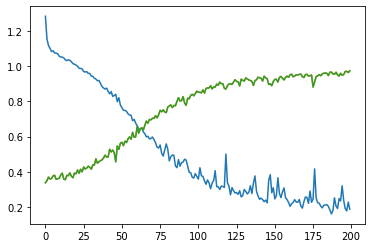

In [49]:
plt.plot(train_loss)
plt.plot(val_acc_)
plt.plot(val_f1_)

# Evaluate

In [46]:
resume_dict = torch.load('Checkpoint/best_model.pth', map_location=device) 

classifier.load_state_dict(resume_dict['classifier'])
classifier = classifier.to(device)

<All keys matched successfully>

In [47]:
print(eval())

  0%|          | 0/20 [00:00<?, ?it/s]

(tensor(0.9730, device='cuda:1'), 0.973046875)


# Submission

In [103]:
df = pd.read_csv("NLP_Data/test.csv")#[['summary','positives','negatives','overall']]
df['overall'] = -1
df

,ID,Place,location,date,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall
0,5,startup_1,"Los Angeles, CA","Jul 19, 2018",Former Employee,Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5,5,5,5,5,49,-1
1,6,startup_1,"Mountain View, CA","Dec 9, 2018",Former Employee,SDE2,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,NaN,4,4,4,5,4,1,-1
2,7,startup_1,"New York, NY","Dec 11, 2018",Current Employee,Software Engineer,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,NaN,5,4,4,5,4,0,-1
3,8,startup_1,NaN,"Dec 11, 2018",Former Employee,Anonymous Employee,great place to work and progress,"work culture, benefits, growth, people,",No cons that i can think of,NaN,5,5,5,5,5,0,-1
4,9,startup_1,"New York, NY","Dec 10, 2018",Current Employee,Anonymous Employee,Google Surpasses Realistic Expectations,Great products. Vision you can feel good about...,Younger employees complaining about the compan...,NaN,5,5,5,5,5,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29267,66959,startup_6,NaN,"Jun 4, 2012",Current Employee,Solution Specialist,great place to grow!,Great health benefits. Many internal job oppor...,Red Tape. Tough to negotiate internal politics...,NaN,4,4,5,4,4,0,-1
29268,66965,startup_6,NaN,"May 31, 2012",Current Employee,Senior Program Manager,An ocean of opportunities,diverse set of people and problems they solve....,sometimes feels like a behemoth trying to get ...,align workgroups and incentives better to crea...,1,3,5,4,2,0,-1
29269,66968,startup_6,NaN,"Jun 1, 2012",Current Employee,Software Development Engineer In Test (SDET),Tech Gaint,Equip its employees wid huge salaries :D,High qualification required to join it,Good Going....try searching new and bigger tal...,3,3,3,3,3,0,-1
29270,66978,startup_6,NaN,"Jun 8, 2012",Former Employee,Senior Systems Engineer,Terrible,They had great health benefits (no longer im t...,* 14 hour days * no idea how to run a service ...,Learn to excel (no pun intended) and ignore mo...,1,1,1,3,1,3,-1


In [104]:
df = preprocess_df(df)
df

,ID,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall
0,5,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5,5,5,5,5,49,-1
1,6,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,,4,4,4,5,4,1,-1
2,7,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,,5,4,4,5,4,0,-1
3,8,great place to work and progress,"work culture, benefits, growth, people,",No cons that i can think of,,5,5,5,5,5,0,-1
4,9,Google Surpasses Realistic Expectations,Great products. Vision you can feel good about...,Younger employees complaining about the compan...,,5,5,5,5,5,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
29267,66959,great place to grow!,Great health benefits. Many internal job oppor...,Red Tape. Tough to negotiate internal politics...,,4,4,5,4,4,0,-1
29268,66965,An ocean of opportunities,diverse set of people and problems they solve....,sometimes feels like a behemoth trying to get ...,align workgroups and incentives better to crea...,1,3,5,4,2,0,-1
29269,66968,Tech Gaint,Equip its employees wid huge salaries :D,High qualification required to join it,Good Going....try searching new and bigger tal...,3,3,3,3,3,0,-1
29270,66978,Terrible,They had great health benefits (no longer im t...,* 14 hour days * no idea how to run a service ...,Learn to excel (no pun intended) and ignore mo...,1,1,1,3,1,3,-1


In [105]:
submit_dataset = TextDataset(df, tokenizer, model.bert, 'data_submit')
submit_loader = torch.utils.data.DataLoader(submit_dataset, 
                                           batch_size=BS, 
                                           shuffle=True,
                                           collate_fn=collate_dict)

  0%|          | 0/29272 [00:00<?, ?it/s]

In [106]:
classifier.eval()
ID = []
overall = []
with torch.no_grad():
    accuracy = 0
    for inp in tqdm(submit_loader, leave=False):        
        out_logits = classifier(inp['summary'].double(), 
                                inp['pos'].double(), 
                                inp['neg'].double(), 
                                inp['advice'].double(), 
                                inp['scores1_5'].double(), 
                                inp['score6'].double())
        predictions = out_logits.argmax(dim=-1)
        
        overall.append(predictions)
        ID.append(inp['ID'])


JointClassifier(
  (dropout1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln1): Linear(in_features=25, out_features=64, bias=True)
  (ln2): Linear(in_features=64, out_features=31, bias=True)
  (ln3): Linear(in_features=32, out_features=128, bias=True)
  (ln4): Linear(in_features=128, out_features=64, bias=True)
  (ln5): Linear(in_features=3072, out_features=64, bias=True)
  (ln6): Linear(in_features=128, out_features=512, bias=True)
  (ln7): Linear(in_features=512, out_features=128, bias=True)
  (ln8): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
)

  0%|          | 0/229 [00:00<?, ?it/s]

In [115]:
df_out = pd.DataFrame({'ID':torch.cat(ID).tolist(), 'overall':(torch.cat(overall)+1).tolist()})
df_out.sort_values('ID').to_csv('submission.csv', index=False)

In [116]:
!head submission.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ID,overall
5,5
6,3
7,4
8,5
9,3
11,4
12,4
13,4
14,3
